<a href="https://colab.research.google.com/github/LiyaUnknown/Ai_Faces_Generation/blob/main/Faces_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# for removing all generated images from file


import os

directory = '/content/'

files = os.listdir(directory)

for file1 in files:
    if 'generation_image_epoch' in file1:
        file_path = os.path.join(directory, file1)
        os.remove(file_path)

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import glob
from IPython import display

In [ ]:
main_path = '/content/drive/MyDrive/face_geeration_datasets/'
imges_paths = os.listdir(main_path)


def prepro(img) :
    img = tf.cast(img , dtype = tf.float32) / 255.0
    img = tf.image.resize(img , (96 , 96))

    return img

def load_img(img) :
    img = tf.io.read_file(main_path + img)
    img = tf.image.decode_jpeg(img , channels=3)

    return prepro(img)


images = tf.data.Dataset.from_tensor_slices(imges_paths)
images = images.map(load_img).shuffle(60000).batch(1)




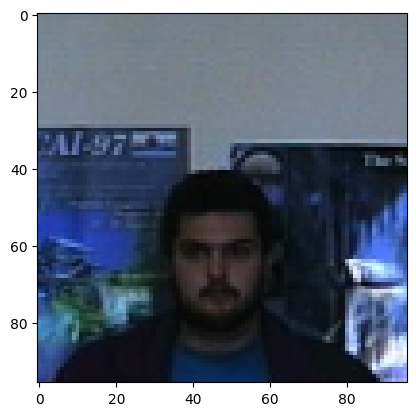

In [ ]:
plt.imshow(list(images)[0][0])
plt.show()

In [ ]:
def mk_dis() :

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv2D(3 , (2,2) ,use_bias = False , padding = 'same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(64 , (2,2) ,use_bias = False , padding = 'same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(64 , (2,2) ,use_bias = False , padding = 'same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(128 , (2,2) ,use_bias = False , padding = 'same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(256 , (2,2) ,use_bias = False , padding = 'same' ))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())


    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    model.add(tf.keras.layers.LeakyReLU(0.3))


    return model




In [ ]:
discriminator = mk_dis()
print(discriminator(tf.expand_dims(list(images)[0][0] , axis = 0) , training = True))
print(discriminator(tf.expand_dims(np.random.rand(96 , 96 , 3) , axis = 0) , training = True))

tf.Tensor([[-0.37229258]], shape=(1, 1), dtype=float32)
tf.Tensor([[-0.2108139]], shape=(1, 1), dtype=float32)


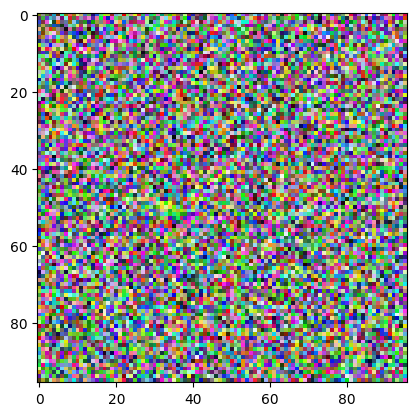

In [ ]:
noises = np.random.rand(96 , 96 , 3)
plt.imshow(noises)
plt.show()

In [ ]:
def make_gen() :

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(3*3*256 , use_bias = False , input_shape = (100 , )))
    model.add(tf.keras.layers.Reshape((3 , 3, 256)))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2DTranspose(256 , (2,2) , (2,2) ,use_bias = False , padding = 'same'))
    model.add(tf.keras.layers.Activation(tf.nn.softplus))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2DTranspose(128 , (2,2) , (2,2) ,use_bias = False , padding = 'same'))
    model.add(tf.keras.layers.Activation(tf.nn.softplus))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2DTranspose(64 , (2,2) , (2,2) ,use_bias = False , padding = 'same'))
    model.add(tf.keras.layers.Activation(tf.nn.softplus))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2DTranspose(64 , (2,2) , (2,2) ,use_bias = False , padding = 'same'))
    model.add(tf.keras.layers.Activation(tf.nn.softplus))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2DTranspose(3 , (2,2) , (2,2) ,use_bias = False , padding = 'same' ))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('sigmoid'))

    print(model.output_shape)

    return model



(None, 96, 96, 3)


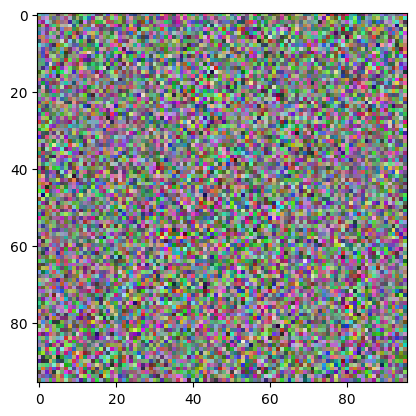

In [ ]:
generator = make_gen()
n = generator(tf.random.normal((1 , 100))  , training = True)
plt.imshow(np.squeeze(n))
plt.show()

In [ ]:
gen_op = tf.keras.optimizers.Adam(0.0001)
dis_op = tf.keras.optimizers.Adam(0.0001)

loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def gen_loss(noises) :
    fake_ = tf.zeros_like(noises)
    return loss(fake_ , noises)

def dis_loss(dis , noises)  :
    fake_ = tf.ones_like(noises)
    real_ =  tf.zeros_like(dis)

    res = loss(real_ , dis) + loss(fake_ , noises)

    return res


In [ ]:

chkp_d = '/content/chkp_dir'
prefix = os.path.join(chkp_d , 'points')
check_p = tf.train.Checkpoint(generator_optimizer=gen_op,
                                 discriminator_optimizer=dis_op,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
gen_images_num = 1
noises = tf.random.normal([gen_images_num , 100])
def trin_step(images) :
    global noises
    with tf.GradientTape() as g , tf.GradientTape() as d :

          gen = generator(noises, training = True)
          fake_ = discriminator(gen , training = True)

          real_ = discriminator(images , training = True)

          gen_l = gen_loss(fake_)
          dis_l = dis_loss(real_ , fake_)

    ge_gr = g.gradient(gen_l , generator.trainable_variables)
    ds_gr = d.gradient(dis_l , discriminator.trainable_variables)

    gen_op.apply_gradients(zip(ge_gr , generator.trainable_variables))
    dis_op.apply_gradients(zip(ds_gr , discriminator.trainable_variables))


In [ ]:
noises = tf.random.normal([1 , 100])

for i in images :
    n = discriminator(i , training = True)
    print(dis_loss(n , noises))

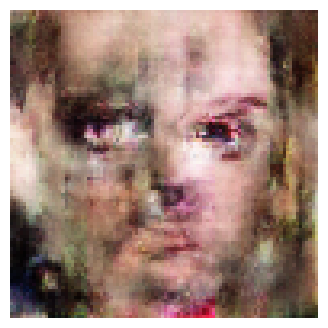

This model is in epoch 42 as 300


In [ ]:
def save_gen_img(model , epoch , random_noise) :

    img_ = model(random_noise , training = True)

    plt.figure(figsize = (4 , 4))


    plt.imshow(img_[0 , : , : , :] )
    plt.axis('off')

    plt.savefig(f'generation_image_epoch: {epoch}')
    plt.show()

noises = tf.random.normal([1 , 100])

def fit(data_st , epochs ) :
    global images

    for epoch in range(1 , epochs) :
        for im in data_st :
            trin_step(im)

        display.clear_output(wait=True)
        save_gen_img(generator , epoch+1 , noises)
        if (epoch + 1) % 15 == 0 :
            check_p.save(prefix)
        print(f'This model is in epoch {epoch} as {epochs}')
    display.clear_output(wait=True)
    save_gen_img(generator , epoch+1 , noises)
fit(images , 300)